<a href="https://colab.research.google.com/github/GayathriBinukumargeetha/ENGG-680--GROUP-30/blob/main/Assignment2_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 2: Introduction to Non-linear Square and Machine Learning*

## Preliminary: Certificate of Work (5 marks)


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Gayathri | Binukumar Geetha | Gayathri Binukumar Geetha |12 Hours | 33% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **PART 1: Non-linear Estimation - LSE & Gradiant Decent (35 Marks)**

The following materials will be our states of interest, and we are going to estimate them using **Least Square method** and **Gradient Descent method**

## **SinglePointPositioning Formulas**

### **Observations:** Pseudorange [m]

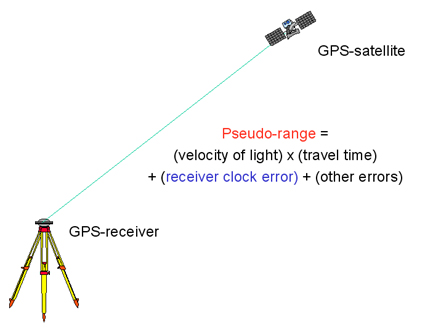

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.


## **Setup & Intialization for LSE and Gradient Decent (5 Marks)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load the psuedorange measurements and satellites' positions files, store them in the format of numpy array
# Add small random perturbations in the range (0, 0.5) to pseudorange measurements to simulate measurement noise
# (hint: use pandas library to parse excel files into dataframe first, then convert them to numpy arrays)
# (1 marks)
# Load the pseudorange measurements and satellites' positions files
df_pseudorange = pd.read_excel("pseudoranges.xlsx")
df_sat_pos = pd.read_excel("satellite_position.xlsx")

np.random.seed(42)  # For reproducible results

# Convert to numpy arrays and add small random noise (0 to 0.5)
pseudorange = df_pseudorange['P'].values.astype(float) + np.random.uniform(0, 0.5, df_pseudorange.shape[0])
sat_pos = df_sat_pos.values.astype(float)



In [ ]:
# define the number of measurements n and the number of unknown states m
# (2 mark)

n = pseudorange.size        # number of observations (should be 11)
m = 4                       # unknown states: x, y, z, receiver clock bias


In [ ]:
# GroundTruth coordiantes of the receiver
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

In [ ]:
# define a function called euclidean_norm, which computes the geometric distances between satellites and receiver
# the input of the function should be two arrays: receiver_pos and satellite_pos
# the function should return an array of distance between satellites and receiver
# you can either use the numpy function or code the math manually
# (2 marks)


def euclidean_norm(receiver_pos, satellite_pos):
    """
    receiver_pos : array-like (3,) -> [x, y, z] in meters
    satellite_pos: array-like (n, k) -> columns (..., sx, sy, sz) in meters
    returns      : array of distances (n,)
    """
    r_x, r_y, r_z = receiver_pos

    s_x = satellite_pos[:, -3]
    s_y = satellite_pos[:, -2]
    s_z = satellite_pos[:, -1]

    distance = np.sqrt((r_x - s_x)**2 + (r_y - s_y)**2 + (r_z - s_z)**2)
    return distance


## **Non-linear LSE (15 Marks)**

### Step 1: Given that the variance of observation is 1.2 (m^2), define the weight matrix P (0.5 marks)

In [ ]:
# Weight matrix P (variance = 1.2 m^2)
sigma2 = 1.2
P = (1 / sigma2) * np.eye(n)


### Step 2: set the initial states as [100.0, -50.0, 25.0, 1000.0] (0.5 mark)

In [ ]:
x_0 = np.array([100.0, -50.0, 25.0, 1000.0])


### Step 3: initialize the corrections array as 10s, iteration loop counter i as zero and related arrays (1 mark)

In [ ]:
# Step 3: initialize the corrections array as 10s,
# iteration loop counter i as zero and related arrays

delta = np.ones(m) * 10.0     # corrections start large so while loop runs
i = 0                         # iteration counter

# arrays to store results for plotting
arr_w = []        # norm of residuals
arr_delta = []    # norm of position corrections (x,y,z)
arr_err_pos = []  # 3D position error vs GroundTruth
arr_i = []        # iteration numbers

# estimated unknown states start from initial guess x_0
x_hat = x_0.copy()



### Step 4: define a function named design_matrix which computes the design matrix A of this LSE problem (3 mark)

the input of this funciton should be: estimated unknown states array, satellites positions array and geometric distance array

the function should return an two-dimensional array which represents the design matrix A

#### Calculation Formula for the Design Matrix \( A \)

Let the position vectors of the satellite and receiver be:

- **r** = (r_x, r_y, r_z) for the receiver
- **s** = (s_x, s_y, s_z) for the satellite

The Euclidean distance between the satellite and receiver is given by:

$$
\rho = \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2}
$$

#### Partial Derivatives of the Distance with Respect to \(x\), \(y\), and \(z\):

To construct the design matrix, we compute the partial derivatives of the distance function with respect to the receiver's \(x\), \(y\), and \(z\) coordinates. Here's the detailed process for one of them, and the others follow the same procedure.

##### Partial derivative with respect to \(r_x\):

Taking the derivative with respect to \(r_x\), we use the chain rule:

$$
\frac{\partial \rho}{\partial r_x} = \frac{\partial}{\partial r_x} \left( \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2} \right)
$$

First, apply the derivative of the square root:

$$
\frac{\partial \rho}{\partial r_x} = \frac{1}{2 \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2}} \cdot 2 (r_x - s_x)
$$

Simplifying:

$$
\frac{\partial \rho}{\partial r_x} = \frac{r_x - s_x}{\rho}
$$

##### Partial derivatives for \(r_y\) and \(r_z\):

The partial derivatives with respect to \(r_y\) and \(r_z\) follow the same procedure:

$$
\frac{\partial \rho}{\partial r_y} = \frac{r_y - s_y}{\rho}
$$

$$
\frac{\partial \rho}{\partial r_z} = \frac{r_z - s_z}{\rho}
$$

#### The Design Matrix \(A\):

Thus, the design matrix \(A\) can be expressed as:

$$
A = \left[
\begin{array}{ccc|c}
\frac{s_x - r_x}{\text{distance}} & \frac{s_y - r_y}{\text{distance}} & \frac{s_z - r_z}{\text{distance}} & -1
\end{array}
\right]
$$

Where:
- The first three columns represent the partial derivatives of the distance with respect to x, y, and z coordinates
- The last column of -1 corresponds to the constant term in the least squares equation

This matrix is used for least squares estimation in positioning or navigation applications.


In [ ]:
#  STEP 4: design_matrix function (REPLACE YOUR OLD ONE)

def design_matrix(receiver_pos, satellite_pos, distance):
    """
    receiver_pos : array-like (4,) -> [x, y, z, clock_bias] in meters
    satellite_pos: array-like (n, k) -> columns (..., sx, sy, sz) in meters
    distance     : array-like (n,)  -> geometric distances in meters
    returns      : (n,4) matrix A
    """

    # receiver coordinates
    r_x, r_y, r_z, _ = receiver_pos

    # use LAST 3 columns of satellite_pos as ECEF coordinates
    s_x = satellite_pos[:, -3]
    s_y = satellite_pos[:, -2]
    s_z = satellite_pos[:, -1]

    # partial derivatives ∂ρ/∂x, ∂ρ/∂y, ∂ρ/∂z
    A1 = (r_x - s_x) / distance   # ∂ρ/∂x
    A2 = (r_y - s_y) / distance   # ∂ρ/∂y
    A3 = (r_z - s_z) / distance   # ∂ρ/∂z

    # clock bias column: derivative of ρ wrt bias (in meters) is 1
    A4 = np.ones_like(distance)

    # stack into design matrix (n x 4)
    A = np.column_stack((A1, A2, A3, A4))

    return A


### Step 5: start the iteration for the LSE (4 mark)

define the convergence criteria for the 'while' loop

the convergence criteria is that the corrections delta are less than 0.008 (i.e., <0.1 m), for receiver's position x,y,z part

In [ ]:
# STEP 5: start the iteration for the LSE  (REPLACE COMPLETELY)

max_iter = 100          # max iterations
tol      = 1e-4         # convergence threshold for x,y,z (0.0001 m)

# clear history arrays (in case you ran before)
arr_w      = []
arr_delta  = []
arr_err_pos = []
arr_i      = []

for i in range(max_iter):

    # 1) geometric distance between satellites and current receiver estimate
    distance = euclidean_norm(x_hat[:3], sat_pos)          # (n,)

    # 2) design matrix A (n x 4)
    A = design_matrix(x_hat, sat_pos, distance)

    # 3) predicted pseudoranges: geometric distance + clock bias (in meters)
    rho_calc = distance + x_hat[3]                         # (n,)

    # 4) misclosure vector w = observed - computed pseudoranges
    w = pseudorange - rho_calc                             # (n,)

    # 5) normal equations
    N = A.T @ P @ A                                        # (4 x 4)
    U = A.T @ P @ w                                        # (4,)

    # small damping to avoid singular matrix just in case
    N_damped = N + 1e-6 * np.eye(4)

    # 6) solve for corrections Δx
    delta = np.linalg.solve(N_damped, U)                   # (4,)

    # 7) update estimated state
    x_hat = x_hat + delta

    # --- logging for plots (Step 8) ---
    arr_w.append(np.linalg.norm(w))                        # ||w||
    arr_delta.append(np.linalg.norm(delta[:3]))            # ||Δx_xyz||
    err_pos = np.linalg.norm(x_hat[:3] - GroundTruth)      # 3-D position error
    arr_err_pos.append(err_pos)
    arr_i.append(i + 1)                                    # store iteration index (1-based)

    # 8) check convergence (only x,y,z part)
    if np.linalg.norm(delta[:3]) < tol:
        break

# store how many iterations were actually used
num_iterations = len(arr_i)


### Step 6: Results Printing (1 mark)

Print:

* estimated states,
* corrections array,
* estimated measurements residuals,
* A posteriori Variance of Unit Weight,
* Covariance matrix of estimated states,
* number of iterations,
* 3-D position errors


In [ ]:
# STEP 6: Results Printing

print("===== FINAL RESULTS =====\n")

print("Estimated States (x_hat):")
print(x_hat)

print("\nFinal Corrections (delta):")
print(delta)

print("\nEstimated Measurement Residuals (w):")
print(w)

# A posteriori variance of unit weight
APV = (w.T @ P @ w) / (n - m)
print("\nA Posteriori Variance of Unit Weight (APV):")
print(APV)

# Covariance matrix of estimated states
C_x_hat = APV * np.linalg.inv(A.T @ P @ A)
print("\nCovariance Matrix of Estimated States (C_x_hat):")
print(C_x_hat)

print("\nNumber of Iterations:")
print(i + 1)

# 3-D position error
err_3d = np.linalg.norm(x_hat[:3] - GroundTruth)
print("\n3-D Position Error (meters):")
print(err_3d)



===== FINAL RESULTS =====

Estimated States (x_hat):
[-1.63349246e+06 -3.65162953e+06  4.95248542e+06  6.70247977e+00]

Final Corrections (delta):
[ 1.24723461e-09  3.52856228e-09 -1.05339963e-09 -2.97650371e-09]

Estimated Measurement Residuals (w):
[ 0.20484779  0.34241078 -0.98042662  0.06600716  0.04710038 -1.57078688
 -0.30919803  1.69958911  0.33525003  0.74095415 -0.57574789]

A Posteriori Variance of Unit Weight (APV):
0.9013677131566766

Covariance Matrix of Estimated States (C_x_hat):
[[ 0.3457467   0.07534978 -0.09147658 -0.07903424]
 [ 0.07534978  0.46020454 -0.62851089 -0.3983237 ]
 [-0.09147658 -0.62851089  2.21260707  1.19415431]
 [-0.07903424 -0.3983237   1.19415431  0.75634562]]

Number of Iterations:
6

3-D Position Error (meters):
5.4258018439460525


### Step 7: Comment on the computed A Posteriori Variance of Unit Weight value and the Covariance matrix of estimated states (1 mark)

In [ ]:
# The A Posteriori Variance of Unit Weight (APV) is ≈ 0.90, which is very close to 1.
# This means the residuals are consistent with the assumed observation variance
# (1.2 m²); our stochastic model is appropriate and the adjustment is of good quality.

# The diagonal elements of C_x_hat are the variances of the estimated states:
#   var(x) ≈ 0.35, var(y) ≈ 0.46, var(z) ≈ 2.21, var(clock) ≈ 0.76,
# giving 1σ standard deviations of about:
#   σ_x ≈ 0.6 m, σ_y ≈ 0.7 m, σ_z ≈ 1.5 m and σ_clock ≈ 0.9 m.
# These relatively small values indicate that the estimated receiver position
# and clock bias are statistically precise.

# The off-diagonal terms show correlations between states; in particular,
# z and the clock bias are strongly correlated, which is typical in GNSS
# (vertical error and clock error are partially interchangeable). Overall,
# the APV and covariance matrix together indicate a well-behaved, reliable solution.


### Step 8: Using the imported matplotlib, plot the following. Make sure to include proper axes information, legend, grid lines and title. (3 marks)

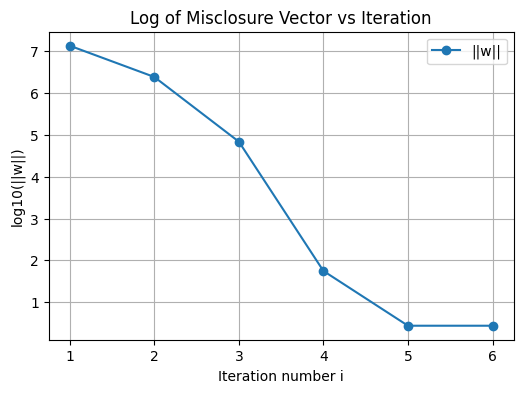

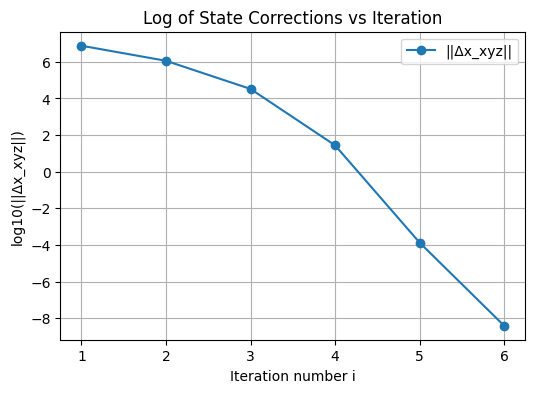

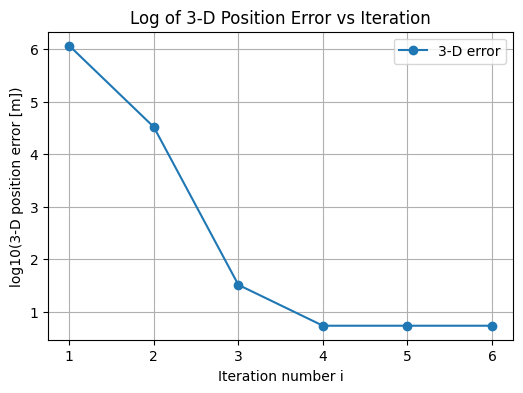

In [ ]:
# 1. Plot log of the misclosure w against the LSQ iteration number i
plt.figure(figsize=(6,4))
plt.plot(arr_i, np.log10(np.array(arr_w) + 1e-12), marker='o')
plt.xlabel("Iteration number i")
plt.ylabel("log10(||w||)")
plt.title("Log of Misclosure Vector vs Iteration")
plt.grid(True)
plt.legend(["||w||"])
plt.show()

# 2. Plot log of the corrections delta against the LSQ iteration number i
plt.figure(figsize=(6,4))
plt.plot(arr_i, np.log10(np.array(arr_delta) + 1e-12), marker='o')
plt.xlabel("Iteration number i")
plt.ylabel("log10(||Δx_xyz||)")
plt.title("Log of State Corrections vs Iteration")
plt.grid(True)
plt.legend(["||Δx_xyz||"])
plt.show()

# 3. Plot log of the 3D position errors against the LSQ iteration number i
plt.figure(figsize=(6,4))
plt.plot(arr_i, np.log10(np.array(arr_err_pos) + 1e-12), marker='o')
plt.xlabel("Iteration number i")
plt.ylabel("log10(3-D position error [m])")
plt.title("Log of 3-D Position Error vs Iteration")
plt.grid(True)
plt.legend(["3-D error"])
plt.show()


### Step 9: Describe the phenomena or pattern you recognize for each plot, and explain such phenomena (1 marks)

In [ ]:
# your answer here


### Bonus: this is just for fun (no marks allocated)

now that you have estimated the receiver's position in Earth-center-earth-fixed (ECEF)

you can use this tool: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm to convert it to latitude, longitude and height

and find where is it on google earth!

## **Non-linear Gradient Decent (15 Marks)**

### Step 0: Intialize empty arrays (there is no need to fill anything here)

In [ ]:
# Step 0: Initialize empty arrays (nothing to fill here)

arr_cost = []     # to store cost function values at each iteration
arr_grad = []     # to store gradient norm values
arr_err  = []     # to store error (3-D position error)
steps_count = 0   # iteration counter


### Step 1: Define the Cost Function (1 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(rec_pos, cdt, sat_pos, pseudorange):
    # rec_pos: receiver 3D position estimate (x, y, z)
    # cdt: receiver clock bias (in meters)
    # sat_pos: satellite coordinates (n x 3)
    # pseudorange: observed pseudoranges (n,)

    # 1. Compute geometric distances from receiver to satellites
    distance = euclidean_norm(rec_pos, sat_pos)   # shape (n,)

    # 2. Predicted pseudoranges = geometric distance + clock bias
    rho_calc = distance + cdt                    # shape (n,)

    # 3. Residuals = observed - predicted
    w = pseudorange - rho_calc                  # shape (n,)

    # 4. Cost = sum of squared residuals
    L = np.sum(w**2)

    return L


### Step 2: Define the Gradient Computation Function (1 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


**Recall elements of the design matrix A in the previous LSE function.**

In [ ]:
# Gradient of the cost function with respect to (x_r, y_r, z_r, cdt)
def gradient(rec_pos, cdt, sat_pos, pseudorange):

    # 1. Compute geometric distances (n,)
    distance = euclidean_norm(rec_pos, sat_pos)

    # 2. Predicted pseudoranges
    rho_calc = distance + cdt

    # 3. Misclosure vector w = observed - predicted (n,)
    w = pseudorange - rho_calc

    # 4. Build the design matrix A (n x 4)
    #    Recall:
    #    A[i,0] = -(x_s - x_r) / distance[i]
    #    A[i,1] = -(y_s - y_r) / distance[i]
    #    A[i,2] = -(z_s - z_r) / distance[i]
    #    A[i,3] = -1
    A = np.zeros((len(sat_pos), 4))
    for i in range(len(sat_pos)):
        A[i,0] = -(sat_pos[i,0] - rec_pos[0]) / distance[i]
        A[i,1] = -(sat_pos[i,1] - rec_pos[1]) / distance[i]
        A[i,2] = -(sat_pos[i,2] - rec_pos[2]) / distance[i]
        A[i,3] = -1.0

    # 5. Gradient = -2 * A^T * w  (from sum of squared residuals)
    grad = -2 * (A.T @ w)

    return grad    # shape (4,)


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.08, 10000, 8e-7 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, sat_pos, learning_rate=0.08, max_iters=10000, tolerance=8e-7):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([50.0, -25.0, 15.0, 500.0])

    for iteration in range(max_iters):
        rec_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = #...

        # compute the gradients in the current step
        # (1 mark)
        grad = #...


        # update estimates
        # (1 mark)
        X_new = #...

        # compute the new cost
        # (1 mark)
        new_cost = #...

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (2 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = #...

# print the mentioned metrics
# ...

### Step 5: Cost vs Steps Plot & Analysis (1 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# (0.5 marks)
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern (0.5 marks)
# ...

### Step 6: Gradients vs Steps & Analysis(1 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# (0.5 marks)
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern (0.5 marks)
# ...

### Step 7: Positioning errors vs Steps & Analysis(1 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# (0.5 marks)
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# (0.5 marks)
# ...

### **Hyperparameters Tuning**

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.008, 0.0008 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.008
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# (1 marks)
optimized_params_2 = #...

# print the metrics
# ...

In [ ]:
#set learning rate to 0.008
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# (1 marks)
optimized_params_3 = #...

# print the metrics
# ...

### Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)


In [ ]:
# your answer here
#

---
---

# **PART 2: Student Depression Prediction using Logistic Regression (30 Marks)**

The following depression dataset aims at analyzing, understanding, and predicting depression levels among students. It is collected from Shodolamu Opeyemi, and it can be downloaded from https://www.kaggle.com/datasets/hopesb/student-depression-dataset

**Dataset Description:**
- Features include academic pressure, age, CGPA, financial stress, work/study hours, and other psychological factors
- Target variable: Depression status (0 = Not Depressed, 1 = Depressed)

Follow the steps provided to perform binary classification using logistic regression and complete the analysis for each part.



### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



### Step 1: Data Input (2 marks)

Load the Student Depression Dataset from CSV file into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`

In [ ]:
# Load the Student Depression Dataset
data = pd.read_csv('')

# Basic data preprocessing
data.drop(   )  # Remove irrelevant ID column
data.dropna(   )  # Remove rows with missing values
data.drop_duplicates(   )  # Remove duplicate rows

# Remove 'Other' category entries as they provide no useful information (1 marks)
# your code here


# Print the shape of the dataset after preprocessing and display the first 5 rows using head()
# your code here


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical variables
labelencoder = LabelEncoder()
categorical_columns = ['City', 'Gender', 'Sleep Duration', 'Dietary Habits',
                      'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness',
                      'Degree', 'Profession']

for col in categorical_columns:
    if col in data.columns:
        data[col] = labelencoder.fit_transform(data[col])

# Prepare feature matrix X and target vector y (1 marks)
y =  # Target vector
X =  # Feature matrix

# Display sizes of X and y
# your code here

### Step 2.1: Class Label Histogram (1 marks)

Plot the histogram for each class label to visualize class distribution. Display the exact value of the samples for each class above the respective bins.

In [ ]:
# Check the class distribution of y


# Display exact values for each bin in the histogram
# hint: Use for loop
# your code here


plt.show()

### Step 2.2: Smaller Dataset Creation (1 marks)

We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42

In [ ]:
from sklearn.model_selection import train_test_split

# Create a smaller dataset with 3% of the data (0.5 marks)


# Display sizes of X_small and y_small (0.5 marks)


### Step 3: Implement Machine Learning Model (3 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)  
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (3 x 3 = 9 marks)

Calculate the following for the **three different tests** implemented in Step 3:
1. data size (0.5 mark)
2. number of training samples (0.5 mark)
3. number of testing samples (0.5 mark)
4. training accuracy (0.5 mark)
5. testing accuracy (0.5 mark)
6. log loss (0.5 mark)

### Step 5.1: Visualize Results (2 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, use random_state = 0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Complete steps 3, 4, and 5.1 in this code block
# Note: 70% training set, 30% testing set
# Create a function that calculates all required information

model = LogisticRegression(max_iter=2000)
results = pd.DataFrame(columns=["Data size", "Training samples", "Testing samples",
                               "Training accuracy", "Testing accuracy", "Log loss"])

def evaluate_model(data_tuple):

    # your code here

    return X_train, X_test, y_train, y_test

# Test 1: Full dataset (X and y)

# Test 2: Only first two columns of X and y

# Test 3: Small dataset (X_small and y_small)

print(results)

### Step 5.2: Visualize Classification Errors (3 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis.

In [ ]:
# Retrieve target vector and predicted values for testing set using full dataset
# (1 marks)
# Note: 70% training set, 30% testing set



In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix: confusion_matrix()
# (1 marks)



# Print confusion matrix using a heatmap: sns.heatmap()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat,
           xticklabels=['Not Depressed', 'Depressed'],
           yticklabels=['Not Depressed', 'Depressed'],
           square=True,
           annot=True,
           cbar=True,
           fmt='d',
           cmap='Blues')
plt.xlabel(   )
plt.ylabel(   )
plt.title(   )
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Print classification report: classification_report()
# (1 marks)



### Additional Models Comparison (2 marks)

Let's compare the Logistic Regression with Naive Bayes and K-Nearest Neighbors models on the same dataset.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Compare Logistic Regression, Naive Bayes, and KNN models
# Initialize models (0.5 marks)

models = {

}

# Train and evaluate each model using the full dataset (0.5 marks)
model_results = {}

for name, model_instance in models.items():
    # Train the model


    # Make predictions


    # Calculate accuracy


    # Print results



In [ ]:
# Visualize confusion matrices for all models (You can use heatmap again)
# (1 marks)






plt.show()

### Questions and Analysis (7 marks)

1. Is the dataset balanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (1 marks)  
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (1 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (1 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (1 marks)
7. Compare the performance of Logistic Regression, Naive Bayes, and K-Nearest Neighbors models. Which performs best and why? Explain based on each algorithm's characteristics and assumptions. (1 marks)

### Answer here (double click)


---
---

# **PART 3: MNIST Handwritten Digit Classification using MLP & CNN (30 Marks)**

This part compares two neural network architectures for handwritten digit classification:
- **Multi-Layer Perceptron (MLP)**: A traditional fully-connected neural network
- **Convolutional Neural Network (CNN)**: A specialized architecture for image processing


The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. This dataset we're using uses the work of Joseph Redmon to provide the MNIST dataset in a CSV format. And it can be downloaded from https://www.kaggle.com/datasets/hojjatk/mnist-dataset

The dataset consists of two files:
- mnist_train.csv
- mnist_test.csv

The mnist_train.csv file contains the 60,000 training examples and labels. The mnist_test.csv contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

Acknowledgements:
- Yann LeCun, Courant Institute, NYU
- Corinna Cortes, Google Labs, New York
- Christopher J.C. Burges, Microsoft Research, Redmond

![MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

We'll train both models on the MNIST dataset and compare their performance.

### Step 1: Library Imports

Import the necessary libraries for data processing, model building, and evaluation.

In [ ]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Step 2: Dataset Loading (2 marks)

Load the MNIST dataset from CSV files. The MNIST dataset contains 70,000 images of handwritten digits (0-9).

Then visualize some sample images.

In [ ]:
# Load MNIST dataset from CSV files
train_csv_path =
test_csv_path =

# Load training data
# The first line is the label, the rest are pixel values
# (0.5 marks)
train_data =
y_train =
X_train =

# CSV stores each image as a single row of 784 pixels, but we need 28x28 matrix for image processing
# Reshape from flat array (784,) to 2D image format (28, 28)
# (0.5 marks)
X_train =

# Load test data (0.5 marks)
test_data =
y_test =
X_test =

# Reshape test data to match training data format (0.5 marks)
X_test =

# Display the shapes of training and test sets


Let's visualize some sample images to understand what our models will be learning from.

In [ ]:
# Visualize sample images from the dataset as a grid of 10 images (2 rows x 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample MNIST Handwritten Digits', fontsize=16, fontweight='bold')

# Display 10 random samples
# Use a loop
for i in range(10):
    row = i // 5
    col = i % 5

    # Get a random sample
    idx = np.random.randint(0, len(X_train))
    image = X_train[idx]
    label = y_train[idx]

    # Display the image
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Data Preprocessing (1 mark)

Normalize pixel values to [0,1] range and convert labels to one-hot encoding for multi-class classification.

Why normalize? Neural networks work better with smaller input values (0-1 vs 0-255)
- Faster convergence during training
- Prevents gradient explosion/vanishing
- Makes learning more stable

Why one-hot? Transform labels from integers (0,1,2...9) to binary vectors

- Example: label "3" becomes [0,0,0,1,0,0,0,0,0,0]

- This allows softmax output layer to predict probabilities for each class

In [ ]:
# Normalize pixel values from [0, 255] to [0, 1] range
# hint: divide by 255.0 (0.5 marks)

X_train_normalized =
X_test_normalized =

# Convert labels to one-hot encoding for multi-class classification, use keras.utils.to_categorical to do it
# (0.5 marks)
num_classes = 10
y_train_categorical =
y_test_categorical =


### Step 4: MLP Model Creation and Training (7 marks)

Create a Multi-Layer Perceptron model with fully connected layers. This model treats each pixel as an independent feature.

This created model can be used for fit, predict and evaluate the dataset through calling mlp_model.fit(), mlp_model.predict() and mlp_model.evaluate(), you can consider it as a inbuild model right now.

Hint: We will use tf.keras.layers function, and add flatten layer, hidden layer, dropout layer, hidden layer, dropout layer and output layer.

In [ ]:
# Create MLP model, add each of layers with their parameters

def create_mlp_model():
    model = tf.keras.Sequential([
        # Flatten layer: Convert 2D image (28x28) to 1D array (784 pixels)
        # MLP needs flat input, treats each pixel as independent feature
        # (1 marks)


        # First hidden layer: 128 neurons with ReLU activation
        # ReLU = max(0, x), helps with vanishing gradient problem
        # (1 marks)


        # Dropout layer: Randomly sets 20% of inputs to 0 during training
        # Prevents overfitting by forcing network to not rely on specific neurons
        # (1 marks)


        # Second hidden layer: 64 neurons with ReLU activation
        # Smaller layer creates hierarchical feature learning
        # (1 marks)


        # Another dropout layer for regularization, same with above
        # (1 marks)


        # Output layer: 10 neurons (one for each digit 0-9) with softmax activation
        # Softmax converts outputs to probabilities that sum to 1
        # (1 marks)


    ])

    # Compile model with optimizer, loss function, and metrics
    # Adam: adaptive learning rate optimizer
    # Categorical crossentropy: loss for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Creating the mlp model, and you can use this model to fit and evaluate with the dataset in the following process.
# You don't need to change anything here.
mlp_model = create_mlp_model()
print("MLP Model created")

**Use .fit() to train MLP model**

In [ ]:
# EPOCHS: Number of complete passes through entire training dataset, use 5 epochs
# (0.5 marks)
EPOCHS =

# BATCH_SIZE: Number of samples processed before updating model weights
# Larger batch = more stable gradients but more memory usage
# Use 128 as batch size
# (0.5 marks)
BATCH_SIZE =

# Train MLP model using mlp_model we compile.
# Use 10% of training data for validation, validation_split=0.1
# Silent training (no progress output), verbose=0
mlp_history = mlp_model.fit(
    X_train_normalized, y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0
)


print("MLP training completed")

### Step 5: CNN Model Creation and Training (7 marks)

Create a Convolutional Neural Network with convolutional and pooling layers. This model preserves spatial relationships between pixels.

#### Fundamental Difference between MLP and CCN:

**Key Architectural Differences:**
- **MLP**: Input → Flatten → Dense layers → Output (treats pixels independently)
- **CNN**: Input → Reshape → Conv+Pool layers → Flatten → Dense layers → Output (learns spatial patterns first)

**The CNN Advantage:**
1. **Convolutional Layers**: Extract spatial features (edges, curves, shapes) that MLP cannot detect
2. **Pooling Layers**: Provide translation invariance and reduce computational load
3. **Feature Hierarchy**: Early layers detect simple patterns, deeper layers combine them into complex features
4. **Parameter Sharing**: Same filter applied across entire image, making CNN more efficient

**Why CNNs End with Dense Layers:**
- Convolutional layers act as **feature extractors** (learn "what" is in the image)
- Dense layers act as **classifiers** (decide "which digit" based on extracted features)
- This is a common pattern: **Feature Extraction (CNN) + Classification (MLP)**

**The Real Difference:**
- **MLP Dense layers**: Work with raw pixel values (784 individual numbers)
- **CNN Dense layers**: Work with high-level spatial features learned by convolutional layers

Hint: We will use tf.keras.layers function again, reshape it firstly, then add Conv2D, MaxPooling2D, Conv2D, MaxPooling2D, Conv2D, and do same last two steps like MLP.

In [ ]:
# Similar process with creating MLP model
# Create CNN model - Different from MLP in how it processes spatial information
def create_cnn_model():
    model = tf.keras.Sequential([
        # Reshape: Add channel dimension (28, 28, 1) for grayscale images (0.5 marks)


        # Conv2D: Applies 32 filters of size 3x3 to detect local patterns (edges, curves) (1 marks)


        # Reduces image size by taking maximum value in 2x2 regions (0.5 marks)


        # Conv2D: Second convolutional layer, 64 filters learn more complex patterns (1 marks)


        # MaxPooling2D: Another pooling layer to further reduce spatial dimensions (0.5 marks)


        # Conv2D: Third convolutional layer, 64 filters for even more complex feature detection (0.5 marks)


        # Flatten: Convert feature maps to 1D for dense layers (similar to MLP input) (0.5 marks)


        # Dense layers: Same as MLP, but now working with CNN-extracted features (0.5 marks)

    ])

    # Same compile step with MLP (1 marks)
    model.compile(    )
    return model

# Create the mlp model, and you can use this model to fit and evaluate with the dataset in the following process.
# You don't need to change anything here.
cnn_model = create_cnn_model()
print("CNN Model created")

**Use .fit() to train CNN model**

In [ ]:
# Train CNN model using cnn_model we compile, same parameters as MLP
# (1 marks)
cnn_history =

print("CNN training completed")

### Step 6: Model Evaluation and Comparison (4 marks)

Evaluate both models on the test set and compare their performance with visualizations.

Using .predict(), .evaluate() functions as we used in part2

In [ ]:
# Evaluate both models on test set
# Get test loss and accuracy, make predictions, convert probabilities to class labels

# your code here for mlp (1.5 marks)

# Note: The model outputs class probabilities (softmax). We convert these to discrete class labels by taking the index of the maximum probability (argmax).
# These integer labels (0-9) are required for computing accuracy, building confusion matrices, and for plotting / comparing predicted vs true labels.
mlp_predicted_classes = np.argmax(mlp_predictions, axis=1)

# your code here for cnn (1.5 marks)

# Similarly, convert CNN predicted probabilities to class labels


# Display Results




Performance comparison visualization

In [ ]:
# Create side-by-side bar chart for model accuracy comparison and line plot for training progress comparison
# (1 marks)
# put them in a single figure horizontally
# Add titles, labels, legends for clarity
# hint: use .history() function to get training history from the training step


plt.show()

### Step 7: Prediction Analysis Visualization (4 marks)

Let's examine some specific predictions to see how each model performs on individual samples.

In [ ]:
# Visualize correct and incorrect predictions, create a 3x8 grid
# First row: Both models correct
# Second row: CNN correct, MLP wrong
# Third row: MLP correct, CNN wrong

# Create subplots
# your code here (1 marks)


# Find correct predictions for each case
# Sample for both_correct
both_correct = (mlp_predicted_classes == y_test) & (cnn_predicted_classes == y_test)
both_correct_indices = np.where(both_correct)[0][:8]

# your code here (1 marks)




# Plot examples, you can learn how to plot them from previous plotting code in Part 2
# Add a title for each graph showing the true label and both model predictions
# hint: use for loop to iterate through the indices and plot each image
# your code here (2 marks)









plt.show()

## Questions and Analysis (5 marks)

1. Which model performed better and why? (1 marks)
2. How do the training curves compare between the two models? (1 marks)
3. What does the accuracy improvement percentage tell us? (1 marks)
4. Why didn't we need many epochs for good results? (1 marks)
5. What would happen with more complex images? (1 marks)

## Answer here (double click)
